# Generative Adversarial Network (GAN)
GAN is a class of artificial neural networks, invented by Ian Goodfellow in 2014. It has a very interesting design idea behind it: make neural networks compete against each other in the hope that this competition will push them to excel. GAN consists of two neural networks:
1. Generator: it takes a latent representation of an image and tries to generates a photorealistic image. It offers the same functionalitiy as a decoder in a variational autoencoder.
2. Discriminator: it takes either a fake image from the generator or a real image from the training set as input, and must guess whether the input image is fake or real.

These two component have opposite goals: discriminator tries to tell fake images from the real images, while the generator tries o produce images that look real enough to trick the discriminator.

Each training iteration is divided into two phases:
1. Disciminator training: A batch of real images is sampled from the training set and is completed with an equal numebr of fake images produced by the generator. Discriminator is trained on this dataset for one setup using the binary cross-entropy loss. In this step, backpropagation **only optimizes the weights of the discriminator. The weights of the generators are frozen.**

2. Generator training: We use the generator to produce another batch of fake images, and once again the disciminator is used to tell whether the images are fake or real. We do not use any real images in this step. Importantly, we **only updates the weights of generator and the weights of the discriminator are frozen**.

Difficulties of training GAN
1. the game may end up in *Nash equibrilum* state -- ?? According to the author of the paper, GAN can only reach a single Nash equibrium: that's when the generator produces perfectl realistic images, and the discriminator is forced to guess(50%, 50%). Nothig guarantees that this equibrilum will be reached

2. Mode collapse: When the generator's outputs gradually become less diverse. If it is better at deciving the discriminator with shoes images, it will keep generating even more images of shoes. Gradually, it will forget how to generate other types of images. Meanwhile, the only fake images that the discriminaotr will see will be shoes, so it will also forget how to discriminate fakes images of other classes. Eventually, the discriminator manages to discriminate the fake shoes from the real ones, the generator will be forced to move onto oher classes. The GAN may gradually cycle across a few classes, never really becoming very good at any of them

3. Since the generator and the discriminator are constanyl pushing against each other, their paramters may end up oscillating and becoming unstable! Very sensitive to hyper parameters!


## Simple GAN for Fashion MNIST

### 1. Importing dependencies

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Reshape, Input, Flatten
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Conv2D, Dropout

print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

tensorflow version: 2.2.0
keras version: 2.3.0-tf


### 2. Data preprocessing

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [0]:
#rescale the input data to make it converge faster
X_train = (X_train / 255).astype(np.float32)
X_test = (X_test / 255).astype(np.float32)

#set up the batch dataset 
BATCH_SIZE = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1) #prefetch 1 batch into the memory to reduce the latency

### 3. Model creation 

In [56]:
# generator network -- given a latent representation, produce a photo-realistic image
codings_size = 30
generator = keras.models.Sequential()
generator.add(Input(shape=codings_size))
generator.add(Dense(units=100, activation="selu")) #300 * 100 + 100 (weights + bias)
generator.add(Dense(units=150, activation="selu")) #100 * 150 + 150
generator.add(Dense(units=28*28, activation="sigmoid")) 
generator.add(Reshape([28,28]))
generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_13 (Dense)             (None, 150)               15150     
_________________________________________________________________
dense_14 (Dense)             (None, 784)               118384    
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28)            0         
Total params: 136,634
Trainable params: 136,634
Non-trainable params: 0
_________________________________________________________________


In [57]:
#discriminator -- given the fake images generated from the generator network and the real images from the training set, 
#guess if it is a fake or real image
discriminator = keras.models.Sequential(
    [Input(shape=[28,28]),
     Flatten(),
     Dense(150, activation="selu"),
     Dense(100, activation="selu"),
     Dense(1, activation="sigmoid")
     ]
)
discriminator.summary()

#gan model
gan = keras.models.Sequential([generator, discriminator])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 150)               117750    
_________________________________________________________________
dense_16 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 132,951
Trainable params: 132,951
Non-trainable params: 0
_________________________________________________________________


In [0]:
#discriminator needs to be trained separately
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop") #since it is a binary classification

#generator is trained through gan model.
#we do not update the weights of discriminator model in this phase
discriminator.trainable = False #trainable attribute is used when we compile the method. so discriminator will be traininable when we train on the compiled discrminator network later
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

### 4. Train

In [0]:
#write function for the training loop
def train_gain(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator=gan.layers
    for each in range(n_epochs):
        print(f"Epoch - {each}")
        for X_batch in dataset:
            # phase 1- train the discrminator
            noise = tf.random.normal(shape=[batch_size,codings_size]) #sample the latent representation from gaussian distributions
            generated_images = generator(noise) #generate fake images from the given latent representation
         
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) #combine the real images(X_batch) and the fake images
            y1 = tf.constant( [[0.]] * batch_size + [[1.]] * batch_size) #generate labels
            discriminator.trainable = True #set discriminator trainable
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - train the generator
            noise = tf.random.normal(shape=[batch_size,codings_size]) #sample the latent representation from gaussian distributions
            y2 = tf.constant([[1]] * batch_size) #generate labels for the fake images
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        #generate sample data at this epoch
        latent_representation = tf.random.normal(shape=[1,codings_size])
        images = generator(latent_representation)
        
        plt.imshow(images[0])
        plt.show()

In [0]:
train_gain(gan,dataset, BATCH_SIZE, codings_size)

### 5. Generate images

In [0]:
latent_representation = tf.random.normal(shape=[1,codings_size])
images = generator(latent_representation)

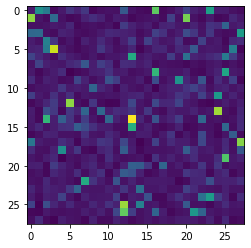

In [61]:
plt.imshow(images[0])

## Deep Convolutional GANs for Fashion MNIST
We can use Convolutional Neural Networks as disciminator & generators for GAN mode. However, it has been proved to be triky, as training was very unstable. But Alec Radford finally succedded in late 2015, after experimenting with many different architectures and hyper-parameters. They called it *Deep Convolutional GAN* (DCGANs). Here is the guideline for building stable convolutional GANs:
1. replace any polling layers with strided conolutions (in the discriminator) and transposed convolutions (in the generator)
2. use bath normaliztion in both the generator and discriminator, except in the generator's output layer and thedisciminator's input layer.
3. Remove fully connected hidden layers for deepr architectures
4. Use ReLU activation in the generator for all layers except the output layer, which should use tanh
5. Use leaky ReLU activaiton in the discriminator for all layers


### Data reprocessing using `tf.Dataset`

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices(np.expand_dims(X_train.astype(np.float32),axis=-1))
dataset = dataset.map(lambda x: x / 255.0 * 2 -1)
dataset = dataset.batch(32, drop_remainder=True).prefetch(1)

### small DCGAN model for Fashion MNIST

In [4]:
codings_size = 100 #latent representation

#generator
generator = keras.models.Sequential()
generator.add(Dense(7*7*128, input_shape=[codings_size])) 
generator.add(Reshape([7,7,128])) #Reshape the input to (7x7x128)
generator.add(BatchNormalization())
#number of filters = 64, kernel = 5x5, same (64, 7, 7, 128)
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"))
generator.summary()

# # of parameter calculations
# input = (None, 100) since tensorflow assume the first dimension to be batch size
print(6272 * 100 + 6272)
# dim = (None, 6272) = 7*7*128 = 6272, params, 6272 * 100 + 6272 =
# dims = (None, 14,14 #filters=64)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

In [5]:
# discriminator
discriminator = keras.models.Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                         activation=keras.layers.LeakyReLU(0.2), input_shape=[28,28,1]))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                         activation=keras.layers.LeakyReLU(0.2)))
discriminator.add(Dropout(0.4))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))
discriminator.summary()

# dimensino check
# same = "zero padding", valid = "without padding"
# (None, 28,28, 1)
# (None, 14,14, 64) #params = 5 * 5 * 64
print(5*5*64 + 64) #number of filters 64, bias + weights

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [0]:
#gan model
DCGAN = keras.models.Sequential([generator, discriminator])

In [0]:
#discriminator needs to be trained separately
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop") #since it is a binary classification

#generator is trained through gan model.
#we do not update the weights of discriminator model in this phase
discriminator.trainable = False #trainable attribute is used when we compile the method. so discriminator will be traininable when we train on the compiled discrminator network later
DCGAN.compile(loss="binary_crossentropy", optimizer="rmsprop")

### Train

Epoch - 0


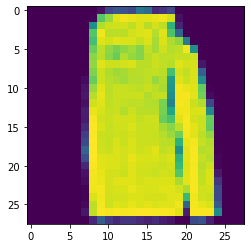

Epoch - 1


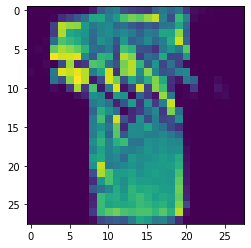

Epoch - 2


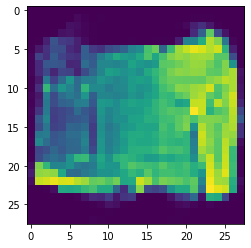

Epoch - 3


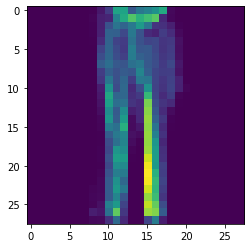

Epoch - 4


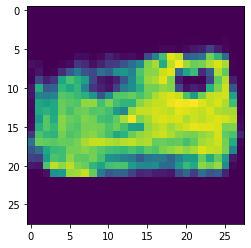

Epoch - 5


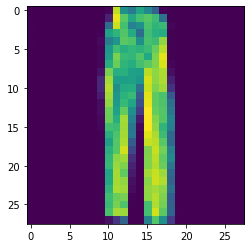

Epoch - 6


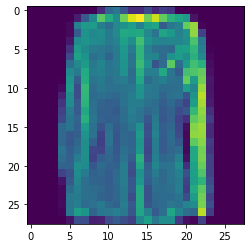

Epoch - 7


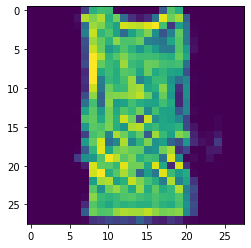

Epoch - 8


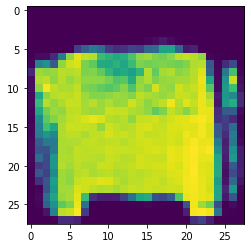

Epoch - 9


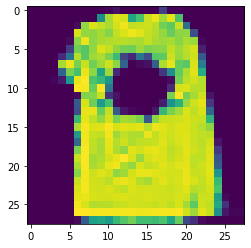

Epoch - 10


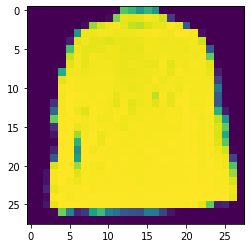

Epoch - 11


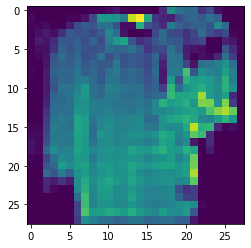

Epoch - 12


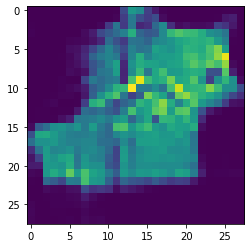

Epoch - 13


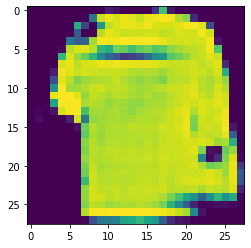

Epoch - 14


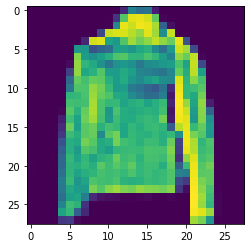

Epoch - 15


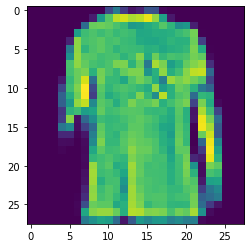

Epoch - 16


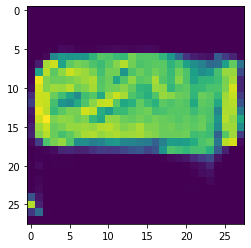

Epoch - 17


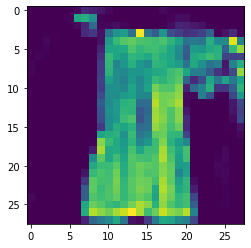

Epoch - 18


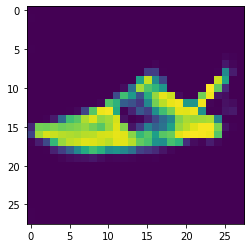

Epoch - 19


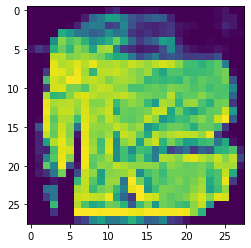

Epoch - 20


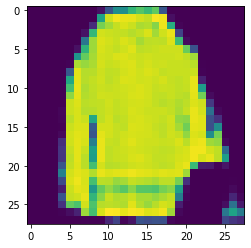

Epoch - 21


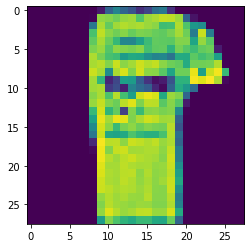

Epoch - 22


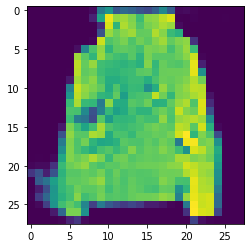

Epoch - 23


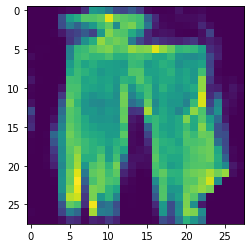

Epoch - 24


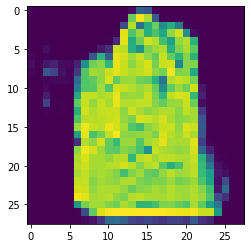

Epoch - 25


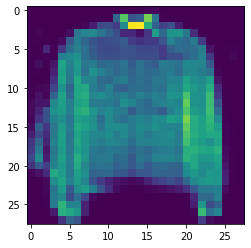

Epoch - 26


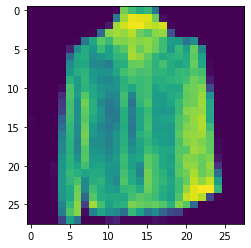

Epoch - 27


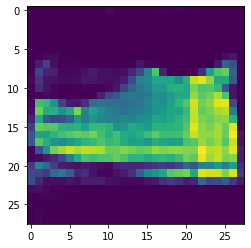

Epoch - 28


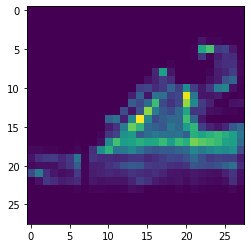

Epoch - 29


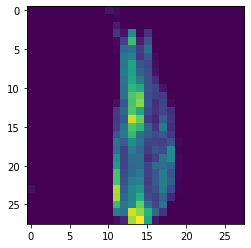

Epoch - 30


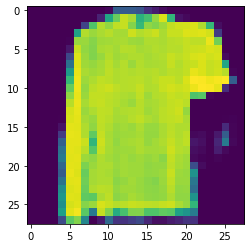

Epoch - 31


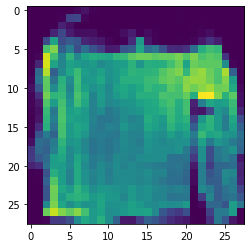

Epoch - 32


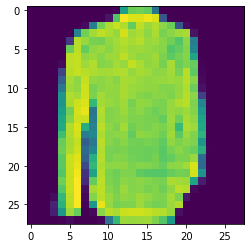

Epoch - 33


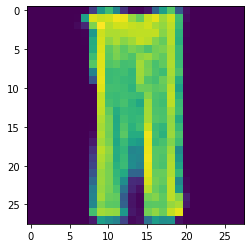

Epoch - 34


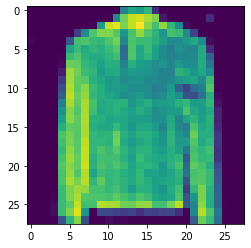

Epoch - 35


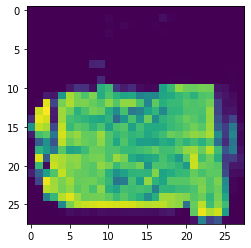

Epoch - 36


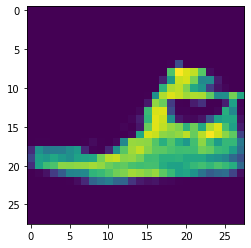

Epoch - 37


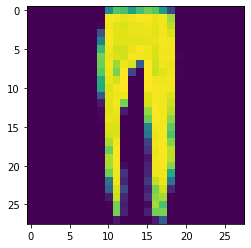

Epoch - 38


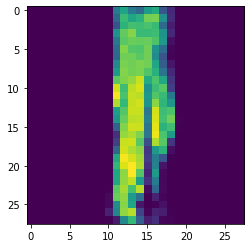

Epoch - 39


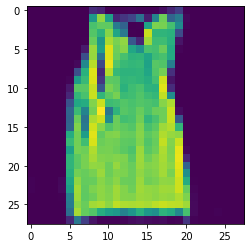

Epoch - 40


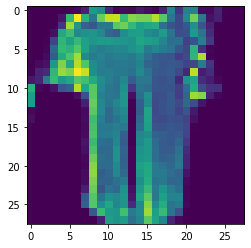

Epoch - 41


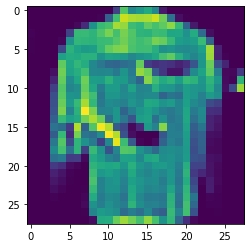

Epoch - 42


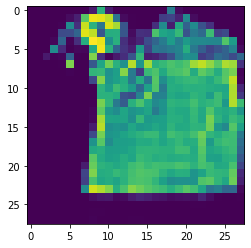

Epoch - 43


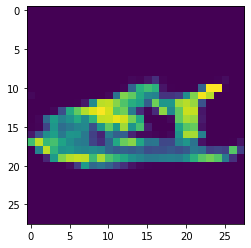

Epoch - 44


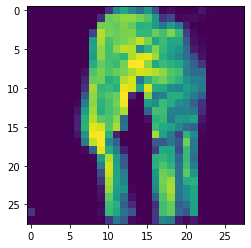

Epoch - 45


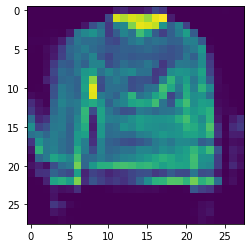

Epoch - 46


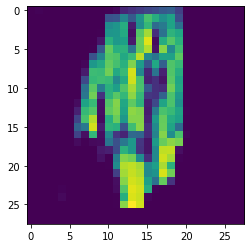

Epoch - 47


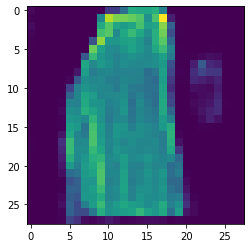

Epoch - 48


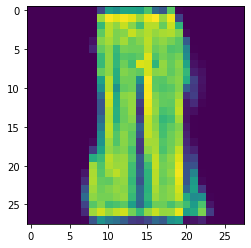

Epoch - 49


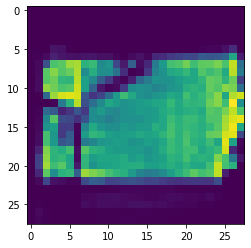

In [13]:
#write function for the training loop
#write function for the training loop
def train_gain(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator=gan.layers
    for each in range(n_epochs):
        print(f"Epoch - {each}")
        for X_batch in dataset:
            # phase 1- train the discrminator
            noise = tf.random.normal(shape=[batch_size,codings_size]) #sample the latent representation from gaussian distributions
            generated_images = generator(noise) #generate fake images from the given latent representation
         
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) #combine the real images(X_batch) and the fake images
            y1 = tf.constant( [[0.]] * batch_size + [[1.]] * batch_size) #generate labels
            discriminator.trainable = True #set discriminator trainable
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - train the generator
            noise = tf.random.normal(shape=[batch_size,codings_size]) #sample the latent representation from gaussian distributions
            y2 = tf.constant([[1]] * batch_size) #generate labels for the fake images
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        #generate sample data at this epoch
        latent_representation = tf.random.normal(shape=[1,codings_size])
        images = generator(latent_representation)
        
        plt.imshow(tf.squeeze(images[0]))
        plt.show()
train_gain(DCGAN, dataset, BATCH_SIZE, codings_size)

DCGAN is not perfect. For example, if you generate a large images, you often end up with locally conving features but overall inconsistencies. How do we resolve this issues?

## Progrssive Growth of GANs
- By Tero Karras at Nvidia research
- Generate small imags at the beginning of training, then gradually adding convolutional layers to both the genrator and the discriminator to produce larger and larger images
- Techniuqes used to make the training mode stable and increase the diversity of the outputs
     1. Minibatch standard deviation layer
     2. Equalized learning rate
     3. Pixelwise normalization layer


## Style GAN
- By same team at Nvidia research
- Uses **style transfer** techniques in the generator to ensure that the generated images have the same local structure as the trining images, at every scale, greatly improving the quality of the generated images.
- It is composed of two networks
     1. Mapping Network: It consists of muultiple dense layers with no activations. These vectors control the style of the generated image at different levels. In short, it maps the latent representations to multiple style vectors.
     2. Synthesis Network: It is reponsible for generating imags. 
- Discriminaotr & the loss function were not modified!!!!! Only the generator is modified as above.
